In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import DiadFit as pf
import os

In [2]:

SEM_data=pd.read_excel('RapidResponse_SI_DatasetS1.xlsx', sheet_name='SEM')
Raman_data=pd.read_excel('RapidResponse_SI_DatasetS1.xlsx', sheet_name='Raman')

In [3]:
import pandas as pd

# Assuming you have two DataFrames SEM_data and Raman_data
# Merge SEM_data into Raman_data based on the specified columns
merged_df2 = Raman_data.merge(SEM_data, left_on='FI Name', right_on='EDS_Name', how='left')
merged_df2.tail()
merged_df2['SO2_mol%']=merged_df2['SO2_mol%'].fillna(0)


In [6]:
# Lets calculate SO2 mol% for all of them from the peak ratios
merged_df2['SO2_mol%']=merged_df2['SO2_mol%'].fillna(0)
SO2_filt=(round(merged_df2['SO2_mol%'])<=5)&(merged_df2['Density g/cm3']>0)
#SO2_filt=(merged_df2['SO2_Diad_Ratio'].fillna(0)<0.19)&(merged_df['Density g/cm3']>0)
merged_df=merged_df2.loc[SO2_filt].reset_index(drop=True)
len(merged_df)

59

In [8]:
import pickle
with open('model.pkl', 'rb') as f:
    poly_pf = pickle.load(f)
merged_df['Temp_from_Fo']=poly_pf(merged_df['Fo'])
# Ones without Fo, fill with Nan
merged_df['Temp_from_Fo']=merged_df['Temp_from_Fo'].fillna(np.nanmean(merged_df['Temp_from_Fo']))

merged_df['P_wFoTemp']=pf.calculate_P_for_rho_T(T_K=merged_df['Temp_from_Fo']+273.15,
                CO2_dens_gcm3=merged_df['Density g/cm3'],
                 EOS='SW96').P_kbar

In [9]:
merged_df['Depth_km_ryanlerner']=pf.convert_pressure_to_depth(P_kbar=merged_df['P_wFoTemp'], model='ryan_lerner')

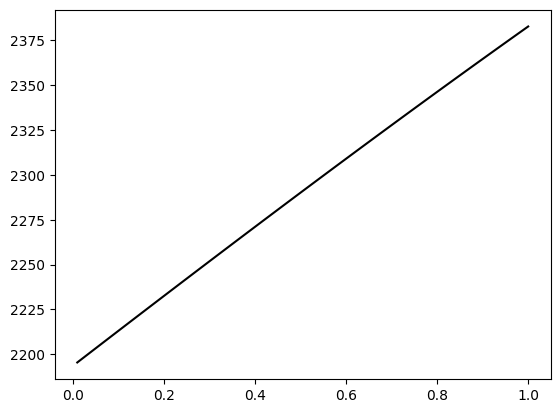

In [10]:
P=np.linspace(0, 1, 100)
D_lerner=pf.convert_pressure_to_depth(P_kbar=P, model='ryan_lerner')
rho_lerner=P/(9.8*D_lerner)
plt.plot(P, rho_lerner*100000, '-k')

working on sample number 0
working on sample number 20
working on sample number 40


,Filename,CO2_dens_gcm3,SingleFI_D_km,SingleFI_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,Mean_MC_D_km,Med_MC_D_km,std_dev_MC_D_km,error_T_K,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS
0,K23_101_FIC,0.085665,1.193235,0.269230,0.268724,0.268271,0.026853,1.194488,1.192197,0.128712,39.681759,0.007736,100.0,1565.805593,0.085665,None,2300,SW96
1,K23_101_FID,0.100137,1.409866,0.318108,0.318116,0.317403,0.027397,1.410254,1.405515,0.139734,39.681759,0.007736,100.0,1565.805593,0.100137,None,2300,SW96
2,K23_102_FIA,0.112454,1.596183,0.360147,0.359998,0.359654,0.028163,1.603061,1.589831,0.147287,39.681759,0.007736,100.0,1564.096549,0.112454,None,2300,SW96
3,K23_10_FIA,0.131039,1.818620,0.410335,0.410038,0.410680,0.028803,1.821669,1.822211,0.149334,39.681759,0.007736,100.0,1510.662458,0.131039,None,2300,SW96
4,K23_1_FIA,0.142919,2.041608,0.460648,0.460809,0.460888,0.031251,2.051546,2.050942,0.165806,39.681759,0.007736,100.0,1539.103462,0.142919,None,2300,SW96


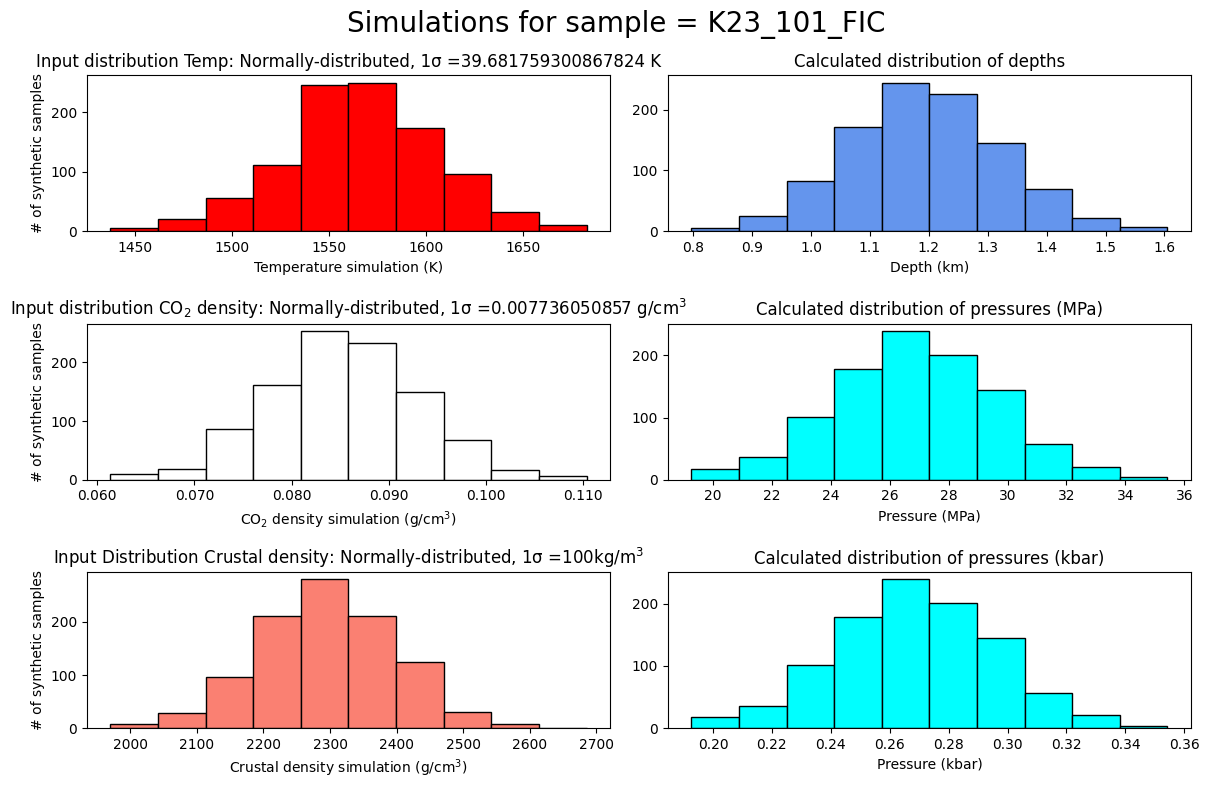

In [11]:
## Lets run a Monte-Carlo simulation to get error on each FI - This uses the Fo content for temperature

MC_Av_rho_T, MC_All_rho_T, fig=pf.propagate_FI_uncertainty(
T_K=merged_df['Temp_from_Fo']+273.15,
error_T_K=np.std(merged_df['Temp_from_Fo']), error_type_T_K='Abs', error_dist_T_K='normal',
CO2_dens_gcm3=merged_df['Density g/cm3'],error_CO2_dens=merged_df['σ Density g/cm3'], error_type_CO2_dens='Abs', error_dist_CO2_dens='normal',
sample_ID=merged_df['FI Name'],

crust_dens_kgm3=2300,
error_crust_dens=100, error_type_crust_dens='Abs', error_dist_crust_dens='normal',
N_dup=1000, fig_i=0, plot_figure=True)
MC_Av_rho_T.head()




In [12]:
# Now merge results into dataframe
full_df=pd.concat([merged_df,MC_Av_rho_T],axis=1)
full_df = full_df.drop(columns=full_df.filter(like='Unnamed'))
display(full_df)
full_df.to_excel(r"final_dataset.xlsx")

,Crystal Name,FI Name,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,...,Med_MC_D_km,std_dev_MC_D_km,error_T_K,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS
0,K23_101,K23_101_FIC,0.085665,0.007736,0.006738,0.003801,102.966450,0.017004,0.000266,0.017044,...,1.192197,0.128712,39.681759,0.007736,100.0,1565.805593,0.085665,None,2300,SW96
1,K23_101,K23_101_FID,0.100137,0.005037,0.003301,0.003805,103.002974,0.008331,0.000264,0.008347,...,1.405515,0.139734,39.681759,0.007736,100.0,1565.805593,0.100137,None,2300,SW96
2,K23_102,K23_102_FIA,0.112454,0.004482,0.002350,0.003817,103.034058,0.005931,0.000273,0.005939,...,1.589831,0.147287,39.681759,0.007736,100.0,1564.096549,0.112454,None,2300,SW96
3,K23_10,K23_10_FIA,0.131039,0.004066,0.001310,0.003849,103.080962,0.003307,0.000262,0.003304,...,1.822211,0.149334,39.681759,0.007736,100.0,1510.662458,0.131039,None,2300,SW96
4,K23_1,K23_1_FIA,0.142919,0.003950,0.000744,0.003879,103.110944,0.001877,0.000258,0.001863,...,2.050942,0.165806,39.681759,0.007736,100.0,1539.103462,0.142919,None,2300,SW96
5,K23_2,K23_2_FIB,0.063799,0.004039,0.001325,0.003816,102.911267,0.003343,0.000251,0.003341,...,0.870297,0.120232,39.681759,0.007736,100.0,1549.503246,0.063799,None,2300,SW96
6,K23_2,K23_3_FIC,0.070903,0.004203,0.001780,0.003808,102.929195,0.004491,0.000249,0.004495,...,0.941171,0.117381,39.681759,0.007736,100.0,1510.662458,0.070903,None,2300,SW96
7,K23_4,K23_4_FIA,0.036928,0.004057,0.001227,0.003867,102.843451,0.003096,0.000247,0.003093,...,0.489150,0.109602,39.681759,0.007736,100.0,1546.529132,0.036928,None,2300,SW96
8,K23_4,K23_4_FIB,0.127203,0.004396,0.002139,0.003841,103.071282,0.005397,0.000247,0.005404,...,1.800405,0.150748,39.681759,0.007736,100.0,1546.529132,0.127203,None,2300,SW96
9,K23_6,K23_6_FIA,0.132034,0.003895,0.000578,0.003851,103.083472,0.001460,0.000247,0.001442,...,1.896092,0.156918,39.681759,0.007736,100.0,1567.713802,0.132034,None,2300,SW96
